In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import collections
import pickle
import gc

In [2]:
df_nostr = pd.read_csv('yt_allcountry_trend5days_nostr.csv', index_col=None)

In [3]:
X = df_nostr.drop(['trend_over_5_days'],axis=1)
y = df_nostr['trend_over_5_days']

In [4]:
X

,views,likes,dislikes,comment_count
0,17158579,787425,43420,125882
1,1014651,127794,1688,13030
2,3191434,146035,5339,8181
3,2095828,132239,1989,17518
4,33523622,1634130,21082,85067
...,...,...,...,...
178694,279728,19691,135,579
178695,1549110,21905,1516,1318
178696,2183462,79677,2034,3464
178697,607422,26166,895,3517


In [5]:
y

0         1
1         0
2         1
3         1
4         1
         ..
178694    0
178695    0
178696    0
178697    0
178698    0
Name: trend_over_5_days, Length: 178699, dtype: int64

### PCA on 4 components?

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

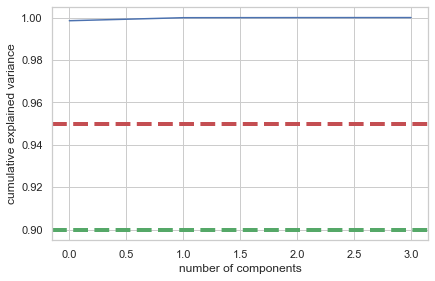

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.998518,0.998518
1,0.999936,0.001419
2,0.999983,0.000047
3,1.000000,0.000017


In [7]:
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
# plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
plt.axhline(linewidth=4, color='r', linestyle = '--', y=0.95, xmin=0, xmax=1)
plt.axhline(linewidth=4, color='g', linestyle = '--', y=0.90, xmin=0, xmax=1)

display(plt.show())

evr = pca.explained_variance_ratio_
cvr = np.cumsum(pca.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
X_train

,views,likes,dislikes,comment_count
113617,126706,6061,64,4418
65534,14658,122,21,9
126111,9568,141,5,10
8740,32051,3006,40,665
57496,11716,2018,6,130
...,...,...,...,...
119879,7996,38,8,14
103694,78227,1082,45,356
131932,98261,501,60,23
146867,16583,177,14,33


### Naive Bayes: Gaussian Naive Bayes

In [10]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, CategoricalNB

In [11]:
GNB = GaussianNB()
GNB.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [12]:
GNB.score(X_test, y_test)

0.9582540570789032

In [13]:
from sklearn.model_selection import cross_val_score

GNB_cvs = cross_val_score(GNB, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(f"GaussianNB 10-CV score: {GNB_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(GNB_cvs)}")

GaussianNB 10-CV score: [0.92126469 0.95422496 0.96552882 0.97437045 0.9616676  0.96614438
 0.96205932 0.96149972 0.95148293 0.95327103]
GaussianNB 10-fold Cross Val Avg: 0.9571513893174485


In [14]:
print(len(GNB.predict_proba(X_test)))
GNB_probs = GNB.predict_proba(X_test)
GNB_probs
# print(min(GNB_probs[0])

44675


array([[9.99960618e-01, 3.93821209e-05],
       [9.99962228e-01, 3.77718098e-05],
       [9.99962180e-01, 3.78195999e-05],
       ...,
       [9.99962636e-01, 3.73642593e-05],
       [9.99962958e-01, 3.70417950e-05],
       [9.99960876e-01, 3.91239063e-05]])

In [15]:
GNB_probs[:,0]

array([0.99996062, 0.99996223, 0.99996218, ..., 0.99996264, 0.99996296,
       0.99996088])

In [16]:
GNB_probs[:,1]

array([3.93821209e-05, 3.77718098e-05, 3.78195999e-05, ...,
       3.73642593e-05, 3.70417950e-05, 3.91239063e-05])

In [17]:
print(f"min of left col = {min(GNB_probs[:,0])}, max of right col = {max(GNB_probs[:,1])}")
print(f"max of left col = {max(GNB_probs[:,0])}, min of right col = {min(GNB_probs[:,1])}")

min of left col = 0.0, max of right col = 1.0
max of left col = 0.999964201117343, min of right col = 3.579888265721081e-05


In [18]:
len(GNB_probs[:,0])

44675

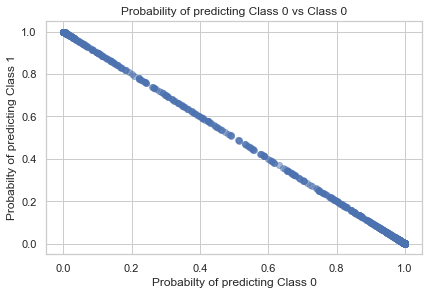

In [19]:
fig, ax = plt.subplots()
plt.scatter(GNB_probs[:,0], GNB_probs[:,1], alpha=0.5)

plt.title('Probability of predicting Class 0 vs Class 0')
ax.set_xlabel('Probabilty of predicting Class 0')
ax.set_ylabel('Probabilty of predicting Class 1')

plt.show()

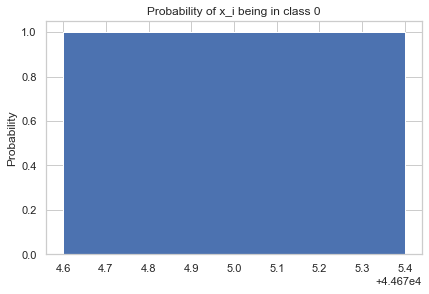

In [20]:
# fig, ax = plt.subplots()

# x_val=len(GNB_probs)

# ax.bar(x_val, GNB_probs[:,0])

# ax.set_ylabel('Probability')
# ax.set_title('Probability of x_i being in class 0')
# plt.show()

In [21]:
count = 0
for val in GNB_probs[:,0]:
    if 0.8 > val > 0.2:
        count += 1
        print(val)

print(f"# of val around 0.5 = {count}")

0.5313009079735511
0.2986362749623305
0.3761078508523502
0.4897592123632969
0.29902407992164654
0.3666816512606012
0.29948757702471085
0.39120794390235136
0.3968722232362767
0.7918497173883419
0.6764707145101211
0.26213940256437424
0.77795133959868
0.24142040254775574
0.5888738075960958
0.441934056596483
0.7148458918320933
0.30628662159838443
0.4105469758301091
0.26649702407312975
0.767137944132495
0.6174123877543661
0.5749667166903683
0.6762486225345712
0.30726207550258355
0.23948604427789177
0.7388656863352253
0.3219343935047197
0.4589465013569462
0.3034210941696149
0.5412469079314483
0.4434604624807761
0.48188031892757793
0.32715992262037735
0.6643972407298976
0.42256942363186906
0.7500083369178604
0.2436540889377728
0.3490087995217405
0.3660010618917253
0.7495895328685551
0.7023873613104943
0.7869541669101832
0.49151123788520196
0.7986715377357028
0.20153067390102125
0.644440050678691
0.6822388528869746
0.5838589651934732
0.7675415305689778
0.35656367968400954
0.5115043427774493
0.

### Calculating GaussianNB Precision, Recall, F1 score. Then "Precision vs. Recall" Plot and F1 score plot

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

In [23]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

In [24]:
len(y_train)

134024

In [25]:
len(GNB_probs[:, 1])

44675

In [26]:
GNB_predicted = GNB.predict(X_test)

In [31]:
GNB_precision = precision_score(y_test, GNB_predicted)
GNB_recall = recall_score(y_test, GNB_predicted)
GNB_f1 = f1_score(y_test, GNB_predicted)

print(f'Precision Score: {GNB_precision}')
print(f'Recall Score: {GNB_recall}')
print(f'F1 Score: {GNB_f1}')

Precision Score: 0.22816032887975335
Recall Score: 0.1661676646706587
F1 Score: 0.19229103508012127


In [ ]:
GNB_probs_2 = cross_val_predict(GNB, X_train, y_train, cv=3,
                                    method="predict_proba")

GNB_class0_scores = GNB_probs_2[:, 0]
GNB_class1_scores = GNB_probs_2[:, 1]
# y_scores_XT = GNB_probs_2[:, 1]
GNB_fpr, GNB_tpr, GNB_thresholds = roc_curve(y_train, GNB_class1_scores)

In [ ]:
GNB_class0_scores

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
#     plt.set_title(lalbe)
    plt.grid(True)                                            # Not shown


In [ ]:
#subplot dotted lines and dots from textbook
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(GNB_fpr, GNB_tpr, "ROC Curve for GaussianNB")

plt.show()

In [ ]:
GNB_precisions, GNB_recalls, GNB_thresholds = precision_recall_curve(y_train, GNB_class1_scores)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(GNB_precisions, GNB_recalls)

plt.show()

## Reappending the prediction probabilites after Gaussian NB back on X_test, to observe some behavior

In [ ]:
X_test_probs = X_test
X_test_probs['prob_0'] = GNB_probs[:,0]
X_test_probs['prob_1'] = GNB_probs[:,1]
X_test_probs['label'] = y_test
X_test_probs

In [ ]:
# to first affirm that prob_0 and prob_1 were truly labeled as what they were supposed to be

count = 0
for i, row in X_test_probs.iterrows():
    count += 1
    if count > 5:
        break
    print(f'i:{i}, V:{row.views}, L:{row.likes}, D:{row.dislikes}, C:{row.comment_count}')
    print(f'i:{i}, Prob_0:{row.prob_0}, Prob_1:{row.prob_1}, Label:{row.label}\n')

In [ ]:
count = 0
for i, row in X_caltest_probs.iterrows():
    if 0.65 > row.prob_0 > 0.45:
        count += 1
        print(f'i:{i}, V:{row.views}, L:{row.likes}, D:{row.dislikes}, C:{row.comment_count}')
        print(f'i:{i}, Prob_0:{row.prob_0}, Prob_1:{row.prob_1}, Label:{row.label}\n')
        
print(f'\nCount = {count}')

### Other observations

In [ ]:
len(X_test)

In [ ]:
np.array(X_test[19:20])

In [ ]:
y_test[19:20]

In [ ]:
GNB.predict_proba(X_test[:-1])

In [ ]:
GNB.predict(X_test[5::-1])

In [ ]:
# custom 
print(GNB.predict(np.array([[17158579, 787425, 43420, 125882]])))
print(GNB.predict_proba(np.array([[17158579, 787425, 43420, 125882]])))

In [ ]:
# custom 
arr2 = [4567, 787, 430, 125]
print(GNB.predict(np.array([arr2])))
print(GNB.predict_proba(np.array([arr2])))

### Using only views, comments, and likes to graph 3D

In [ ]:
X3 = X.drop(['dislikes'],axis=1)
X3

In [ ]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.25, random_state=42)

In [ ]:
X3_train

In [ ]:
y3_train

### Gaussian Naive Bayes on views, comments, likes, only

In [ ]:
GNB_3 = GaussianNB()
GNB_3.fit(X3_train, y3_train)

In [ ]:
GNB_3.score(X3_test, y3_test)

In [ ]:
from sklearn.model_selection import cross_val_score

GNB_3_cvs = cross_val_score(GNB_3, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(GNB_3_cvs)
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(GNB_3_cvs)}")

### Bernoulli Naive Bayes on 4 stats, then the 3 stats

In [ ]:
from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()
BNB.fit(X_train, y_train)

In [ ]:
BNB.score(X_test, y_test)

In [ ]:
BNB_cvs = cross_val_score(BNB, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(f"GaussianNB 10-CV score: {BNB_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(BNB_cvs)}")

In [ ]:
from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()
BNB.fit(X3_train, y_train)

In [ ]:
BNB.score(X3_test, y_test)

In [ ]:
BNB_cvs = cross_val_score(BNB, X, y, 
                          cv=10, 
                          n_jobs=-1,)

print(f"GaussianNB 10-CV score: {BNB_cvs}")
print(f"GaussianNB 10-fold Cross Val Avg: {np.mean(BNB_cvs)}")

### Random Forest Classifier on 4 stats, looking at feature importance

In [ ]:
%%time 
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)

In [ ]:
%%time
rf_clf.score(X_test,y_test)

## Taking a look at feature importance from Random Forest

In [ ]:
# quick investigation into the correlation of features to the label
df_nostr.corr()["trend_over_5_days"].sort_values(ascending=False)

In [ ]:
rf_clf.feature_importances_

In [ ]:
plt.barh(X.columns, rf_clf.feature_importances_)

In [ ]:
%%time
import shap

explainer = shap.TreeExplainer(rf_clf)

In [ ]:
%%time
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shape_values, X_test, plot_type="bar")

In [ ]:
shap.summary_plot(shape_values, X_train)

In [ ]:
# X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
# y = np.array([1, 1, 2, 2])
# from sklearn.svm import SVC
# clf = SVC(probability=True)
# clf.fit(X, y) 
# print(clf.predict([[-0.8, -1]]))
# print(clf.predict_proba([[-0.8, -1]]))

### Heat Map remade with Spearman's rank correlation 

In [ ]:
import seaborn as sns

sns.heatmap(df_nostr.corr(method='spearman'),annot=True,cmap='coolwarm')

In [ ]:
sns.heatmap(df_nostr.corr(method='pearson'),annot=True,cmap='coolwarm_r')

In [ ]:
df_nostr.corr(method='pearson')['trend_over_5_days']